In [1]:
import os
import re

from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
posts_df = pd.read_json('data/stackoverflow/sample/CombinedDocs.100K.Questions.jsonl.gz', lines=True)
print('Original posts: {:,}'.format(len(posts_df.index)))
posts_df.head(5)

Original posts: 273,876


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
0,"[{'_CreationDate': '2013-02-20T21:15:11.130', ...",NaN,NaN,"<p>What event do you want to use as trigger, t...",None,7,None,2013-02-20T21:15:11.130,NaN,14990058,...,{'_AboutMe': '<ul> <li>ASP.NET and Windows-Dev...,None,284240,14989981.0,2,2,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
1,"[{'_CreationDate': '2015-09-14T22:02:20.670', ...",NaN,NaN,"<p>When the build/publish script ran, the wron...",None,0,None,2015-09-14T22:02:20.670,NaN,32574652,...,{'_AboutMe': '<p>Keith lives in SE Florida and...,None,86555,32569215.0,2,0,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
2,"[{'_CreationDate': '2012-06-12T14:02:37.243', ...",NaN,NaN,<p>In the interface add the method declaration...,None,3,None,2012-06-12T14:02:37.243,NaN,10998316,...,"{'_AboutMe': '<h1>SOreadytohelp</h1> ', '_Acco...",None,693272,10998270.0,2,3,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
3,"[{'_CreationDate': '2014-07-30T13:14:15.723', ...",NaN,NaN,<p>Every answer so far is correct and points o...,None,0,None,2014-07-30T13:14:15.723,NaN,25037786,...,{'_AboutMe': '<p>Expertise with</p> <ul> <li>...,None,1649198,25037558.0,2,0,None,None,NaN,None
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None


In [3]:
tag_posts = posts_df.dropna(axis=0, subset=['_Tags'])
print('Posts w/ tags: {:,}'.format(len(tag_posts.index)))
tag_posts.head(5)

Posts w/ tags: 98,278


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None
6,"[{'_CreationDate': '2015-02-02T23:17:47.047', ...",NaN,1.0,<p>Hi this script shows a Google's map in Palo...,None,8,None,2015-02-02T23:17:47.047,NaN,28288660,...,None,None,4472264,NaN,1,1,<javascript><wordpress><google-maps><google-ma...,Google Map API v3 not working in Wordpress,503.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
8,"[{'_CreationDate': '2019-01-23T15:37:18.230', ...",NaN,1.0,<p>I'm creating an app (personal project) that...,None,2,None,2019-01-23T15:37:18.230,NaN,54330748,...,None,None,2913976,NaN,1,1,<ruby-on-rails><ruby><ruby-on-rails-4><activer...,Trying to collect a list of ids from checkboxe...,37.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
15,"[{'_CreationDate': '2014-11-16T09:15:33.277', ...",26955818.0,2.0,<p>I want to change item color and it's parent...,None,0,None,2014-11-16T09:15:33.277,NaN,26955440,...,None,None,3839473,NaN,1,1,<javascript><jquery><html><css>,change font color when clicking on menu with j...,872.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
19,"[{'_CreationDate': '2008-09-30T15:00:01.233', ...",155597.0,3.0,<p>I have a VB6 COM component which I need to ...,None,0,None,2008-09-30T15:00:01.233,NaN,153438,...,"{'_AboutMe': '<p><a href=""http://www.leapinggo...",Wolfwyrd,15570,NaN,1,0,<c#><.net><com><interop>,Retrieving the original error number from a CO...,2120.0,None


In [4]:
tag_posts['_Tag_List'] = tag_posts['_Tags'].apply(lambda x: re.findall('\<(.+?)\>', x))

flat_tags = tag_posts.apply(lambda x: pd.Series(x['_Tag_List']),axis=1).stack().reset_index(level=1, drop=True)
flat_tags.head(5)

/home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4                  php
6           javascript
6            wordpress
6          google-maps
6    google-maps-api-3
dtype: object

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

tag_counts = flat_tags.groupby(flat_tags).count().sort_values(ascending=False)
print(tag_counts[0:10])

javascript    10080
java           8792
c#             7374
php            7303
python         6470
android        6399
jquery         5471
html           4817
c++            3579
css            3397
dtype: int64


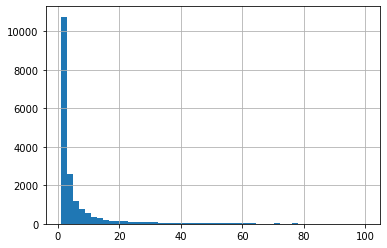

In [6]:
tag_counts[tag_counts <= 100].hist(bins=50)

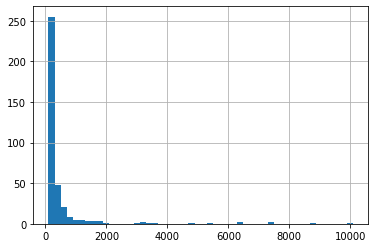

In [7]:
tag_counts[tag_counts > 100].hist(bins=50)

In [8]:
from collections import defaultdict
# import seaborn as sns

tag_counts = defaultdict(int)

for row in tag_posts['_Tag_List']:
    for tag in row:
        tag_counts[tag] += 1

for i in [0, 10, 20, 50, 100, 1000]:
    filtered_tags = list(filter(lambda x: x > i, tag_counts.values()))
    print('There are {:,} tags with more than {:,} count'.format(len(filtered_tags), i))

MIN_TAGS = 1000

record_count = len([i for i in filter(lambda x: x > MIN_TAGS, tag_counts.values())])
record_count

There are 18,549 tags with more than 0 count
There are 2,730 tags with more than 10 count
There are 1,589 tags with more than 20 count
There are 709 tags with more than 50 count
There are 367 tags with more than 100 count
There are 33 tags with more than 1,000 count


33

In [9]:
all_tags = set()
for row in tag_posts['_Tag_List']:
    for tag in row:
        if tag_counts[tag] > MIN_TAGS:
            all_tags.add(tag)

print('Total unique tags with {:,} occurrences: {:,}'.format(MIN_TAGS, len(all_tags)))
sorted_all_tags = sorted(all_tags)

tag_to_id = {val:i for i, val in enumerate(sorted_all_tags)}
id_to_tag = {i:val for i, val in enumerate(sorted_all_tags)}

Total unique tags with 1,000 occurrences: 33


In [10]:
labels = []
tag_list = tag_posts['_Tag_List'].tolist()

# Loop through every post...
for i, tag_set in enumerate(tag_posts['_Tag_List'].tolist()):
    # Then build a record_count element wide list for each tag present
    label_row = []
    for tag in sorted_all_tags:
        if tag in tag_list[i]:
            label_row.append(1)
        else:
            label_row.append(0)
    labels.append(label_row)
    
tag_labels = [id_to_tag[key_id] for key_id in sorted(id_to_tag.keys()) if tag_counts[id_to_tag[key_id]] > MIN_TAGS]

len(labels), len(labels[0]), len(tag_labels)

(98278, 33, 33)

In [15]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

MAX_LEN = 150
PAD_TOKEN = '__PAD__'
BATCH_SIZE = 32

def extract_text(x):
    """Extract non-code text from posts (questions/answers)"""
    doc = BeautifulSoup(x)
    codes = doc.find_all('code')
    [code.extract() if code else None for code in codes]
    tokens = doc.text.split()
    padded_tokens = [tokens[i] if len(tokens) > i else PAD_TOKEN for i in range(0,MAX_LEN)]
    return padded_tokens

post_text = tag_posts._Body.apply(extract_text)
post_text

4         [This, is, what, i, have., I, need, to, break,...
6         [Hi, this, script, shows, a, Google's, map, in...
8         [I'm, creating, an, app, (personal, project), ...
15        [I, want, to, change, item, color, and, it's, ...
19        [I, have, a, VB6, COM, component, which, I, ne...
26        [I, have, some, troubles, with, a, wav, readin...
32        [I, have, a, simple, web, page, where, for, ea...
33        [How, I, can, list, all, branches, in, SVN, re...
34        [I, am, working, with, JSF, 2.1,, Netbeans, 7....
36        [It, seems, to, be, a, Bootstrap, bug., When, ...
39        [I, have, developed, a, shiny, app,, first, ha...
47        [I, have, a, UserControl, with, many, fields, ...
48        [Is, there, a, tool, that, can, allow, me, to,...
52        [I'd, like, to, be, able, to, add, text, to, t...
53        [I, have, this, python, file, in, the, same, f...
54        [i, have, employee, and, department, in, datab...
61        [Please, explain, how, is, thi

In [16]:
len(post_text.index), len(post_text.iloc[0]), len(labels), len(labels[0])

(98278, 150, 98278, 33)

In [17]:
# Validate the posts match the labels
assert(len(post_text.index) == len(labels))
print('We are left with {:,} example posts'.format(len(post_text.index)))

We are left with 98,278 example posts


In [18]:
# TRAINING_COUNT = 9984 - 8
TRAINING_COUNT = BATCH_SIZE * MAX_LEN * 2

# Filter rows with all 0s for tags
label_mx = np.array(labels)
max_per_row = label_mx.max(axis=1)
non_zero_index = np.nonzero(max_per_row)[0]

label_mx = label_mx[non_zero_index][0:TRAINING_COUNT]

post_text = post_text[post_text.index.isin(non_zero_index)]
post_text = post_text[0:TRAINING_COUNT].tolist()
post_text = np.array(post_text)

len(post_text), label_mx.shape

(9600, (9600, 33))

In [19]:
post_text

array([['This', 'is', 'what', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['I', 'want', 'to', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['I', 'have', 'a', ..., 'get', 'the', 'Error'],
       ...,
       ['This', 'is', 'the', ..., '__PAD__', '__PAD__', '__PAD__'],
       ['Out', 'put', 'Original', ..., '__PAD__', '__PAD__', '__PAD__'],
       ["I've", 'written', 'a', ..., '__PAD__', '__PAD__', '__PAD__']],
      dtype='<U829')

In [20]:
# From https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/

sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(BATCH_SIZE*[MAX_LEN])
                            #"sequence_len": tf.constant(TRAINING_COUNT * [MAX_LEN])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

W0718 14:55:14.162420 139702015878976 module_wrapper.py:136] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [21]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    post_text,
    label_mx,
    test_size=TEST_SPLIT,
    random_state=34
)

len(X_train), len(X_test), y_train.shape, y_test.shape

(8640, 960, (8640, 33), (960, 33))

In [22]:
from keras.layers import Input, concatenate, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout, Lambda, Bidirectional
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Model
from keras.optimizers import Adam
from keras_metrics import precision, f1_score, false_negative, true_positive, false_positive, true_negative

# Text model
text_input = Input(shape=(MAX_LEN,), dtype=tf.string)

elmo_embedding = Lambda(ElmoEmbedding, output_shape=(MAX_LEN, 1024))(text_input)

text_lstm = LSTM(
    input_shape=(MAX_LEN, 1024,),
    units=512,
    recurrent_dropout=0.2,
    dropout=0.2)(elmo_embedding)

text_dense = Dense(record_count, activation='sigmoid')(text_lstm)

# text_batch = BatchNormalization()(text_dense)

text_model = Model(
    inputs=text_input, 
    outputs=text_dense
)

def abs_KL_div(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sum(K.abs( (y_true - y_pred) * (K.log(y_true / y_pred))), axis=-1)

from keras.optimizers import Adam
adam = Adam(lr=0.001)

text_model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=[
        precision(),
        f1_score(),
        true_positive(),
        false_positive(),
        true_negative(),
        false_negative(),
        abs_KL_div,
        'mae'
    ]
)

text_model.summary()

W0718 14:55:18.245649 139702015878976 deprecation.py:506] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0718 14:55:18.440678 139702015878976 module_wrapper.py:136] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0718 14:55:18.446779 139702015878976 deprecation.py:323] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has t

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 150, 1024)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dense_1 (Dense)              (None, 33)                16929     
Total params: 3,164,705
Trainable params: 3,164,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
class_freq = np.sum(label_mx, axis=0) / label_mx.shape[0]
class_weights = (1 / class_freq).tolist()
class_weights_dict = {i:val for i, val in enumerate(class_weights)}

class_weights_dict

{0: 43.24324324324324,
 1: 64.0,
 2: 11.162790697674419,
 3: 60.0,
 4: 45.07042253521127,
 5: 33.333333333333336,
 6: 51.33689839572193,
 7: 9.213051823416507,
 8: 20.96069868995633,
 9: 21.192052980132452,
 10: 54.857142857142854,
 11: 65.3061224489796,
 12: 15.262321144674086,
 13: 20.869565217391305,
 14: 57.485029940119766,
 15: 8.648648648648647,
 16: 7.430340557275541,
 17: 13.40782122905028,
 18: 48.484848484848484,
 19: 92.3076923076923,
 20: 22.535211267605636,
 21: 44.44444444444444,
 22: 39.83402489626556,
 23: 9.736308316430021,
 24: 10.126582278481012,
 25: 49.740932642487046,
 26: 64.0,
 27: 64.42953020134229,
 28: 45.933014354066984,
 29: 23.24455205811138,
 30: 41.92139737991266,
 31: 56.80473372781065,
 32: 60.75949367088608}

In [27]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight('balanced', y_train)
sample_weights

array([1.68214598e-07, 2.90921782e-07, 4.54832456e-09, ...,
       9.28800741e-08, 3.46014160e-07, 4.10863258e-09])

In [ ]:
from keras.callbacks import EarlyStopping

EPOCHS = 4

history = text_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='loss', patience=1, min_delta=0.001),
        EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
    ],
    # class_weight=class_weights_dict,
    sample_weight=sample_weights,
    validation_data=(X_test, y_test)
)

Train on 8640 samples, validate on 960 samples
Epoch 1/4
3296/8640 [==========>...................] - ETA: 1:24 - loss: 8.1316e-07 - precision: 0.0370 - f1_score: 0.0522 - true_positive: 7.0000 - false_positive: 182.0000 - true_negative: 3035.0000 - false_negative: 72.0000 - abs_KL_div: 213.4161 - mean_absolute_error: 0.4445

In [ ]:
accr = text_model.evaluate(X_test, y_test, class_weight=class_weights_dict)
[i for i in zip(accr, text_model.metrics_names)]

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

print(history.history)
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_abs_KL_div'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import hamming_loss, jaccard_score

import keras.backend as K
import tensorflow as tf

y_pred = text_model.predict(X_test)

sess = tf.Session()
with sess.as_default():
    for cutoff in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8]:
        y_pred_bin = K.greater(y_pred, cutoff).eval()
        print('Cutoff: {:,}'.format(cutoff))
        print('Hamming loss: {:,}'.format(
            hamming_loss(y_test, y_pred_bin)
        ))
        for j_type in ['micro', 'macro', 'weighted']:
            print('Jaccard {} score: {:,}'.format(
                j_type,
                jaccard_score(y_test, y_pred_bin, average=j_type)
            ))

In [ ]:
y_pred